# Notebook for embedding dimension study

In [1]:
%matplotlib inline

## Dataset loading
So far, a single source dataset is used

In [2]:
#% Imports
import pandas as pd

#% Data import
#% engine=python because C engine has an error with a character in the middle of
## the file. May be slower but works.

df = pd.read_csv('../Datasets/macdonalds_for_guillaume.csv', engine='python')

## Dataset structure

This work has been moved to the file [dataset.py](dataset.py)

In [3]:
from dataset import Dataset

Using TensorFlow backend.


## Utility functions
* examine_cv gives a quick overview of a cross validation result
* filter_text filters characters from a text

This work has been moved to [utils_npi.py](utils_npi.py)

In [4]:
from npi_utils import examine_cv, filter_text, remove_double

## Models


These classes are used to handle different kind of models seamlessly  
This has been moved to the [models.py](models.py) file

In [5]:
import models

We will use only 1 model to evaluate this.  
The one chosen is the GRU 1 layer 64 cells. This one has good performances and is fast to train. It uses embedding dimension so we can focus on this part.  
Also, it is not too complex, so it should be weak to embedding changes (and easier to analyze).

## Adding datasets
First we add the basic texts set.  
Stemming may help some models. So we will create an additional dataset with the stemmed texts

In [6]:
from nltk import SnowballStemmer

#% Datasets
datasets = []

#% Basic texts
texts = df['text']
y = df['neg_pi'].values

#% Stem words
stemmer = SnowballStemmer("english")

stemmed_texts = [' '.join([stemmer.stem(w) for w in filter_text(t).split()]) for t in texts]
consonnant_code_texts = [remove_double(filter_text(t, filtered="aeiouy")) for t in stemmed_texts]

print('mcdonalds')
datasets.append(Dataset(texts, y, 'mcdonalds'))

print('stemmed mcdonalds')
datasets.append(Dataset(stemmed_texts, y, 'stemmed mcdonalds'))

for dataset in datasets:
    print(dataset.name, ', vocabulary size :', dataset.vocabulary_size)

mcdonalds
stemmed mcdonalds
mcdonalds , vocabulary size : 42239
stemmed mcdonalds , vocabulary size : 36032


## Start the analysis

In [7]:
import time
from os import path
import os

#% Result file
result_file = 'result_embed.csv'

#% Clear the result file
clear_file = False

#% Models/Datasets done
models_dataset_done = []

if path.exists(result_file) and not clear_file:
    result_content = pd.read_csv(result_file, engine='python')
    models_dataset_done = [(e[0], e[1]) for e in result_content[['model','dataset']].values]
else:
    clear_file = True

if clear_file:
    f = open(result_file, "w")
    f.write('model,dataset,accuracies,mean_acc,std_acc,f1_scores,mean_f1,std_f1,log_loss,mean_log_loss,std_log_loss,roc_auc_scores,mean_roc_auc,std_roc_auc,ms_time\n')
    f.close()
    
embedding_sizes =  [100, 50] + list(range(1, 8))
    
#% Analyze on every dataset
for embedding_size in embedding_sizes:
    model = models.GRU1ModelHandler(embedding_size = embedding_size)
    model_name = ' '.join(model.get_info())
    print('-----')
    print(model_name)

    for dataset in datasets:
        print('Dataset', dataset.name)

        #% Check if it has already been done
        if (model_name, dataset.name) in models_dataset_done:
            print('This has been done already.')
            continue

        cv_accuracies = []
        cv_f1s = []
        cv_logloss = []
        cv_rocaucs = []

        #% Time the cross validation to have an idea on how long it takes to fit
        time1 = time.time()

        #% We used 10 folds cross validation
        for i in range(10):
            cv_accuracies_, cv_f1s_, cv_logloss_, cv_rocaucs_ = model.cross_validate(dataset, 10)
            cv_accuracies += cv_accuracies_
            cv_logloss += cv_logloss_
            cv_f1s += cv_f1s_
            cv_rocaucs += cv_rocaucs_

        time2 = time.time()
        #% Elapsed time in ms
        ms_time = (time2 - time1) * 1000.0

        print('Done, time spent', ms_time, 'ms')

        #% Display a summary of the model perfs
        print('log loss')
        mean_logloss, std_logloss = examine_cv(cv_logloss)
        print('Accuracy scores')
        mean_acc, std_acc = examine_cv(cv_accuracies)
        print('f1 scores')
        mean_f1, std_f1 = examine_cv(cv_f1s)
        print('roc scores')
        mean_roc, std_roc = examine_cv(cv_rocaucs)

        #% Add entry to result file
        file_entry = []
        file_entry.append(model_name)
        file_entry.append(dataset.name)
        file_entry.append(';'.join([str(s) for s in sorted(cv_accuracies)]))
        file_entry.append(str(mean_acc))
        file_entry.append(str(std_acc))
        file_entry.append(';'.join([str(s) for s in sorted(cv_f1s)]))
        file_entry.append(str(mean_f1))
        file_entry.append(str(std_f1))
        file_entry.append(';'.join([str(s) for s in sorted(cv_logloss)]))
        file_entry.append(str(mean_logloss))
        file_entry.append(str(std_logloss))
        file_entry.append(';'.join([str(s) for s in sorted(cv_rocaucs)]))
        file_entry.append(str(mean_roc))
        file_entry.append(str(std_roc))
        file_entry.append(str(ms_time))

        f = open(result_file, "a")
        f.write(','.join(file_entry) + '\n')
        f.close()
        print('Done. Confidence acc :', mean_acc - 2 * std_acc)
    print('-----')

-----
Keras 50 epochs 100 embedding GRU 1 layer 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 50 embedding GRU 1 layer 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 1 embedding GRU 1 layer 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 2 embedding GRU 1 layer 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 3 embedding GRU 1 layer 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 4 embedding GRU 1 layer 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 5 embeddi

## Result gathering and analysis

In [8]:
import pandas as pd
import numpy as np

#% Result file
result_file = 'result_embed.csv'

#% Display result
result_content = pd.read_csv(result_file, engine='python')
result_content

model            dataset  \
0    Keras 50 epochs 1 embedding GRU 1 layer 64 cells          mcdonalds   
1    Keras 50 epochs 1 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
2    Keras 50 epochs 2 embedding GRU 1 layer 64 cells          mcdonalds   
3    Keras 50 epochs 2 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
4    Keras 50 epochs 3 embedding GRU 1 layer 64 cells          mcdonalds   
5    Keras 50 epochs 3 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
6    Keras 50 epochs 4 embedding GRU 1 layer 64 cells          mcdonalds   
7    Keras 50 epochs 4 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
8    Keras 50 epochs 5 embedding GRU 1 layer 64 cells          mcdonalds   
9    Keras 50 epochs 5 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
10   Keras 50 epochs 6 embedding GRU 1 layer 64 cells          mcdonalds   
11   Keras 50 epochs 6 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
12   Keras 50 epochs 7 embedding GRU 1 layer 64 cells          mcdonalds   
13   Keras 50 epochs 7 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
14   Keras 50 epochs 8 embedding GRU 1 layer 64 cells          mcdonalds   
15   Keras 50 epochs 8 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
16   Keras 50 epochs 9 embedding GRU 1 layer 64 cells          mcdonalds   
17   Keras 50 epochs 9 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
18  Keras 50 epochs 10 embedding GRU 1 layer 64 cells          mcdonalds   
19  Keras 50 epochs 10 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
20  Keras 50 epochs 11 embedding GRU 1 layer 64 cells          mcdonalds   
21  Keras 50 epochs 11 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
22  Keras 50 epochs 12 embedding GRU 1 layer 64 cells          mcdonalds   
23  Keras 50 epochs 12 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
24  Keras 50 epochs 13 embedding GRU 1 layer 64 cells          mcdonalds   
25  Keras 50 epochs 13 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
26  Keras 50 epochs 14 embedding GRU 1 layer 64 cells          mcdonalds   
27  Keras 50 epochs 14 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
28  Keras 50 epochs 15 embedding GRU 1 layer 64 cells          mcdonalds   
29  Keras 50 epochs 15 embedding GRU 1 layer 64 cells  stemmed mcdonalds   
30  Keras 50 epochs 100 embedding GRU 1 layer 64 c...          mcdonalds   
31  Keras 50 epochs 100 embedding GRU 1 layer 64 c...  stemmed mcdonalds   
32  Keras 50 epochs 50 embedding GRU 1 layer 64 cells          mcdonalds   
33  Keras 50 epochs 50 embedding GRU 1 layer 64 cells  stemmed mcdonalds   

                                           accuracies  mean_acc   std_acc  \
0   0.9467532634735107;0.9489177465438843;0.949350...  0.954952  0.003274   
1   0.948051929473877;0.9489177465438843;0.9493287...  0.955229  0.003508   
2   0.9458874464035034;0.9471861720085144;0.948029...  0.954082  0.003458   
3   0.9458874464035034;0.9484848380088806;0.949761...  0.954813  0.003358   
4   0.9476190209388733;0.9484848380088806;0.948484...  0.954471  0.003272   
5   0.9463203549385071;0.9467532634735107;0.947619...  0.954943  0.003686   
6   0.9432900547981262;0.9471861720085144;0.948484...  0.954545  0.003460   
7   0.9428571462631226;0.9493506550788879;0.949350...  0.954895  0.003309   
8   0.9467532634735107;0.9476190209388733;0.947619...  0.954341  0.002935   
9   0.9463203549385071;0.9471861720085144;0.947619...  0.954086  0.003590   
10  0.9424242377281189;0.9428571462631226;0.945887...  0.953757  0.003688   
11  0.9450216293334961;0.9454545378684998;0.947186...  0.954198  0.004051   
12  0.9450216293334961;0.948051929473877;0.9484625...  0.954103  0.003480   
13  0.9458874464035034;0.9476190209388733;0.948484...  0.954610  0.003566   
14  0.9463203549385071;0.9471861720085144;0.947641...  0.954090  0.003149   
15  0.9467532634735107;0.948051929473877;0.9484848...  0.954501  0.003617   
16  0.9450216293334961;0.9463203549385071;0.947186...  0.953714  0.003286   
1

In [9]:
#% Recover embedding size for each model
def get_model_embedding(row):
    params = row['model'].split()
    return int(params[params.index('epochs') + 1])

result_content['embedding_size'] = result_content.apply(get_model_embedding, axis=1)

In [10]:
#% Build confidence measures
def confidence(row, value):
    return row['mean_' + value]-2*row['std_' + value]

def df_confidence(df, value):
    result_content['confidence_' + value] = result_content.apply(lambda row:confidence(row, value), axis=1)

df_confidence(result_content, 'acc')
df_confidence(result_content, 'f1')
df_confidence(result_content, 'roc_auc')

In [11]:
#% Product row of the previous categories
result_content['prod'] = result_content.apply(lambda row : row['confidence_acc']*row['confidence_roc_auc']*row['confidence_f1'], axis=1)

In [12]:
#% Unpack roc scores
result_content['roc_auc_scores_'] = result_content.apply(lambda r:list(map(float, r['roc_auc_scores'].split(';'))), axis=1)

mcdonalds


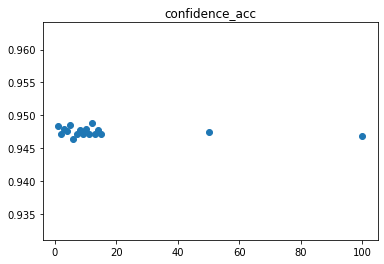

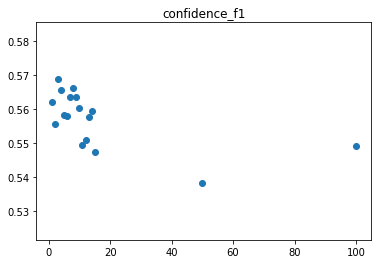

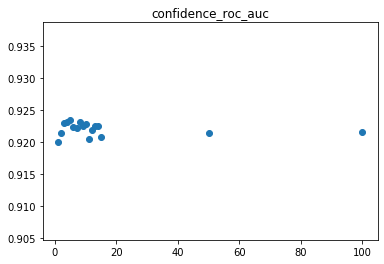

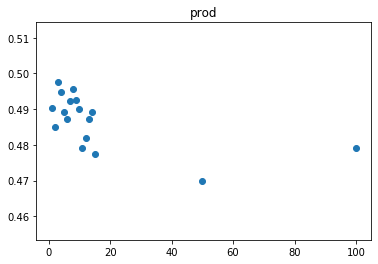

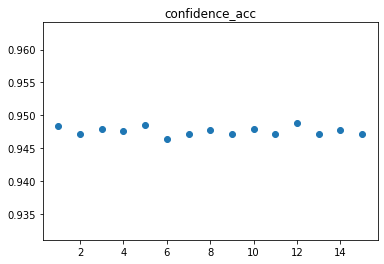

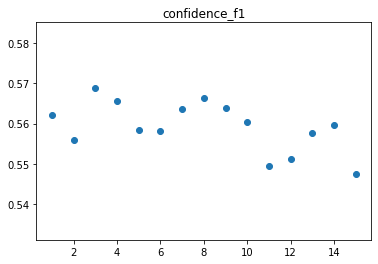

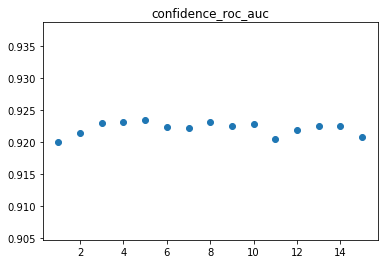

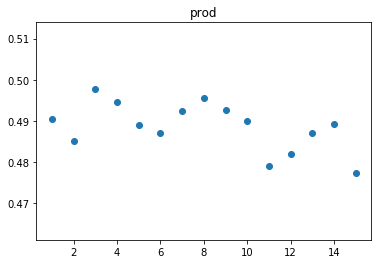

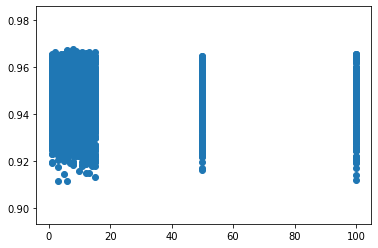

stemmed mcdonalds


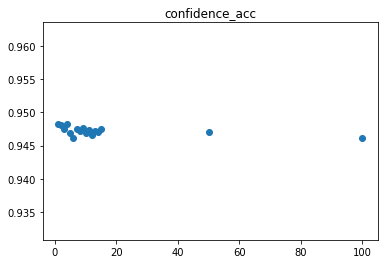

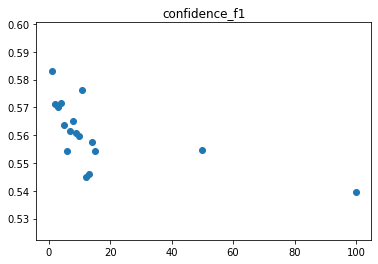

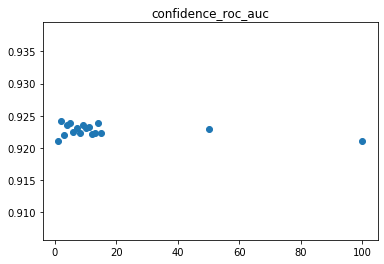

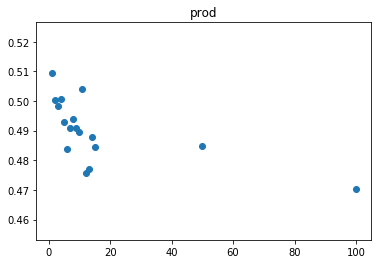

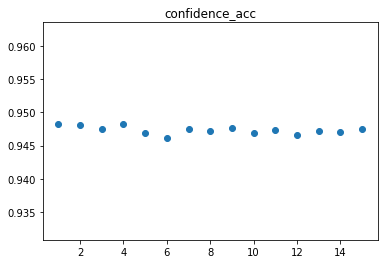

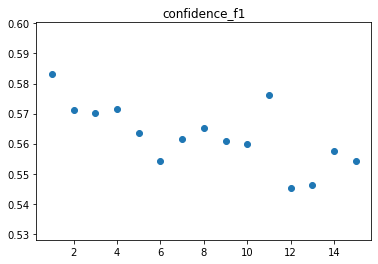

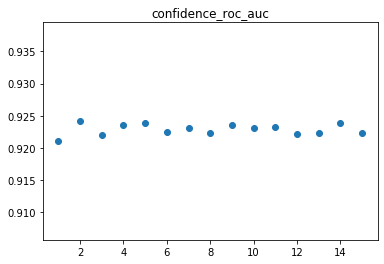

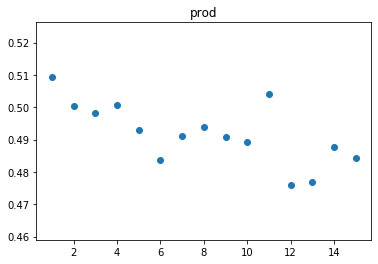

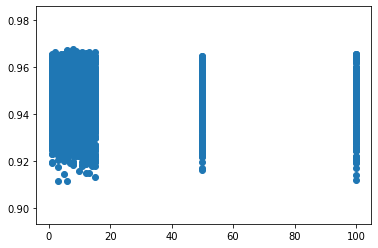

In [13]:
import matplotlib.pyplot as plt

def plot_data(df, col):
    plt.scatter(df['embedding_size'], df[col])
    plt.title(col)
    plt.show()
    
for name, group in result_content.groupby('dataset'):
    print(name)
    plot_data(group, 'confidence_acc')
    plot_data(group, 'confidence_f1')
    plot_data(group, 'confidence_roc_auc')
    plot_data(group, 'prod')
    
    #% Plot the beginning separately
    plot_data(group[group['embedding_size']<50], 'confidence_acc')
    plot_data(group[group['embedding_size']<50], 'confidence_f1')
    plot_data(group[group['embedding_size']<50], 'confidence_roc_auc')
    plot_data(group[group['embedding_size']<50], 'prod')
    
    X = []
    Y = []
    for scores, size in result_content[['roc_auc_scores_', 'embedding_size']].values:
        Y += scores
        X += [size for i in range(len(scores))]
    plt.scatter(X, Y)
    plt.show()

Looks like 4 is a good dimension for embedding

# 1 dim


In [14]:
dataset = datasets[0]
model = models.GRU1ModelHandler(embedding_size = 1)
model.fit(dataset)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 18481 samples, validate on 4621 samples
Epoch 1/50
18481/18481 [==============================] - 2s 126us/step - loss: 0.3445 - accuracy: 0.9286 - val_loss: 0.2504 - val_accuracy: 0.9312
Epoch 2/50
18481/18481 [==============================] - 1s 33us/step - loss: 0.2322 - accuracy: 0.9366 - val_loss: 0.2373 - val_accuracy: 0.9312
Epoch 3/50
18481/18481 [==============================] - 1s 31us/step - loss: 0.2013 - accuracy: 0.9366 - val_loss: 0.2026 - val_accuracy: 0.9312
Epoch 4/50
18481/18481 [==============================] - 1s 32us/step - loss: 0.1499 - accuracy: 0.9425 - val_loss: 0.1510 - val_accuracy: 0.9478
Epoch 5/50
18481/18481 [==============================] - 1s 32us/step - loss: 0.1049 - accuracy: 0.9577 - val_loss: 0.1259 - val_accuracy: 0.9543
Epoch 6/50
18481/18481 [==============================] - 1s 32us/step - loss: 0.0894 - accuracy: 0.9618 - val_loss: 0.1

In [34]:
weights = model.model.layers[0].get_weights()[0]
word_index = dataset.tokenizer.word_index
mapped = [(key, weights[word_index[key]][0]) for key in word_index]
mapped = sorted(mapped, key=lambda x:x[1])
mapped[:10], mapped[-10:]

([('boycott', -0.5919556),
  ('trash', -0.4780901),
  ('diet', -0.41946074),
  ('eat', -0.40495092),
  ("don't", -0.35008085),
  ('hate', -0.34866557),
  ('eating', -0.34703246),
  ('salad', -0.33013955),
  ('eats', -0.31567013),
  ('salads', -0.2637341)],
 [('most', 0.38473946),
  ('ya', 0.38802564),
  ('youtu', 0.40500453),
  ('french', 0.4054163),
  ("there's", 0.40764165),
  ('ronald', 0.41065878),
  ('line', 0.4134883),
  ('ice', 0.41709343),
  ('found', 0.42439166),
  ('imagine', 0.42722368)])